In [13]:
#Retirar Warnings 
from IPython.display import clear_output

# Leitura de Dados
import pandas as pd

# Visualização personalizada e imediata de varios gráficos
import seaborn as sb

# Separação e Treino em Excesso
from sklearn.model_selection import train_test_split, GridSearchCV

# Classificador de Floresta
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Métricas, relatórios e visualização dos mesmos
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
class PsyCleaner:
    """
    Serves the dataframe treatment routine for the current dataset that has been passed

    Args:
        dataLocation (str) # Describes the folder's path to the current used dataframe
        toDrop (list[str]) Optional # All the columns that should be dropped during the routine
    """
    def __init__(self, dataLocation: str, toDrop: list[str] = None):
        self._data_path = dataLocation
        self._dataframe = pd.read_csv(self._data_path)
        self.info = self._dataframe.info
        self._cleaned_dataframe = None
            
    def fix_col_names(self):
        """
        Fix all gaps inside each column name by replacing them with a underscore "_"

        Args:
            self (class instance)

        Returns:
            None
        """
        for col in self._dataframe.columns:
            self._dataframe[col].convert_dtypes()
            self._dataframe.rename(columns={
                col: col.lower().replace(" ", "_")
            }, inplace=True)

    def clean_columns(self, colsToClean: list[str] = None, fillValue = None):
        """
        Fill all the NaN values of the specified columns

        Args:
            colsToClean (list[str]) Optional # Columns that will be cleaned
            fillValue (any) Optional # An value to replace all the NaN
        """
        dataframe = self._dataframe
        if not colsToClean: 
            colsToClean = [
                'academic_pressure',
                'work_pressure',
                'study_satisfaction',
                'job_satisfaction'
            ]
        if not fillValue:
            fillValue = 0
        for cols in colsToClean:
            dataframe[cols].fillna(fillValue, inplace=True)
        return dataframe

    def fix_degrees(self, replaceValues: dict = None):
        """
        Fix the categorical variance of the "degree's"  column by replacing all the different values with a common denominator

        Args:
            replaceValues (dict) Optional # An schema to replace all values.
        """
        if not replaceValues:
            replaceValues = {
                "M.Com": "Master",
                "MD": 'Master',
                "MBBS": "Master",
                "MA": "Master",
                "MHM": "Master",
                "M.Ed": "Master",
                "ME": 'Master',
                "M.Pharm": "Master",
                "M.Tech": "Master",
                "MBA": "Master",
                "MSc": "Master",
                "MCA": "Master",
                "LLM": "Master",
                "PhD": "Master",
                
                # Masters above, Bacharel below
                
                "B.Tech": "Bacharel",
                "LLB": "Bacharel",
                "BE": "Bacharel",
                "B.Pharm": "Bacharel",
                "B.Arch": "Bacharel",
                "BA": "Bacharel",
                "BHM": "Bacharel",
                "BBA": "Bacharel",
                "BSc": "Bacharel",
                "BCA": "Bacharel",
                "B.Ed": "Bacharel",
                "B.Com": "Bacharel",
                "Class 12": "Bacharel"
            }
        self._dataframe['degree'].replace(
            replaceValues
            , inplace=True)
        self._dataframe['degree'].replace({
            "Master": 1,
            "Bacharel": 0
        }, inplace=True)

    def categorical_to_bool_to_int(self, spec_type, col, replace_val: dict = None):
        """
        Complex function that replaces the values (passed by schema or default) and then after it'll convert them into a better type (normally int)

        Args:
            spec_type (type) # The specific type that all the values should be converted into
            col (str) # The specific column that will pass through this treatment
            replace_val (dict) # The schema to replace all the values

        Returns:
            dataframe (pd.DataFrame) 
        """
        if not replace_val:
            replace_val = {
                "Yes": True,
                "No": False
            }
        self._dataframe[col].replace(
            replace_val
        , inplace=True)
        return self._dataframe[col].astype(spec_type)

    def change_diet(self, replaceValue: list[str] = None):
        """
        Change the values in dietary_habits column to a "standardized value"

        Args:
            replaceValue (list[str]) Optional # The schema to replace values

        Returns:
            dataframe (pd.DataFrame)
        """
        dataframe = self._dataframe
        if not replaceValue:
            replaceValue = {
                'Unhealthy': -1,
                'Healthy': 1,
                'Moderate': 0
            }
        dataframe['dietary_habits'].replace(
            replaceValue, 
        inplace=True)
        return dataframe
    
    def study_work_into_general(self, cols: list[str] = None):
        """
        Remove the "non-necessary" (academic and professional fields) columns by creating a general purpose one. 

        Args:
            cols (list[str]) Optional # Non used "deprecated" argument

        Return: 
            dataframe (pd.DataFrame)
        """
        dataframe = self._dataframe
        dataframe["general_pressure"] = dataframe['academic_pressure'] + dataframe['work_pressure']
        dataframe['general_satisfaction'] = dataframe['job_satisfaction'] + dataframe['study_satisfaction']
        dataframe.drop(columns=[
            'academic_pressure', 'work_pressure', 'job_satisfaction', 'study_satisfaction'
        ], inplace=True)
        return dataframe

    def fix_professions(self, replaceValue: str = None, sector_mapping: dict = None):
        """
        Fill the invalid values with "Unemployed" (by default) and then map all the current professions by sector, after it completes that, it'll create a general stress level for each one

        Args:
            sector_mapping (dict) Optional # The immense schema to replace all the professions

        Returns:
            dataframe (pd.DataFrame)
        """
        if not replaceValue:
            replaceValue = "Unemployed"
        
        if not sector_mapping:
            sector_mapping = {
                f'{replaceValue}': 0,  # Usando 0 para 'Unoccupied'
                'Teacher': 1, 'HR Manager': 1, 'Pharmacist': 1, 'Judge': 1, 
                'Plumber': 1, 'Electrician': 1, 'Doctor': 1, 'Lawyer': 1,  # Setor público (1)
                
                'Business Analyst': 2, 'Marketing Manager': 2, 'Financial Analyst': 2, 
                'Finanancial Analyst': 2, 'Sales Executive': 2, 'Customer Support': 2, 
                'Entrepreneur': 2, 'Consultant': 2, 'Travel Consultant': 2, 
                'Chef': 2, 'Manager': 2,  # Setor privado (2)
                
                'Software Engineer': 3, 'Data Scientist': 3, 'Mechanical Engineer': 3, 
                'Civil Engineer': 3, 'UX/UI Designer': 3, 'Graphic Designer': 3, 
                'Architect': 3, 'Digital Marketer': 3, 'Pilot': 3, 'Researcher': 3,  # Setor tecnologia (3)
                
                'Content Writer': 4, 'Chemist': 4, 'Educational Consultant': 4, 
                'Investment Banker': 4, 'Research Analyst': 4, 'Entrepreneur': 4, 
                'Consultant': 4, 'Chef': 4  # Setor liberal (4)
            }
        dataframe = self._dataframe
        dataframe['profession'].fillna(replaceValue, inplace=True)
        
        # Adicionar coluna com setor correspondente
        dataframe['sector'] = dataframe['profession'].map(sector_mapping)
        dataframe['sector'].fillna(0, inplace=True)
        # Calcular a pressão média por setor 
        sector_pressures = dataframe.groupby('sector')['general_pressure'].mean()
        # Mapear o nível de estresse para cada profissão
        dataframe['stress_level'] = dataframe['sector'].map(sector_pressures).astype(int)
        dataframe.drop(columns='profession', inplace=True)
        return dataframe

    def fix_sleep(self, replaceValue: dict = None):
        """
        Create a scale for every possible sleep value

        Args: 
            replaceValue (dict) Optional # The schema for each value to be replaced by

        Returns:
            dataframe (pd.DataFrame)
        """
        if not replaceValue:
            replaceValue = {
                "7-8 hours": 3,
                "Less than 5 hours": 1,
                "5-6 hours": 2,
                "More than 8 hours": 4
            }
        dataframe = self._dataframe
        dataframe['sleep_duration'].replace(
            replaceValue
        , inplace=True)
        return dataframe
    
    def generalProcess(self):
        """
        Basically the app routine
        """
        self._dataframe.drop(columns=['name', 'city', 'cgpa', 'Unnamed: 0'], inplace=True)
        self.fix_col_names()
        self._dataframe = self.clean_columns()
        self._dataframe.rename(columns={
            "working_professional_or_student": 'isWorking'
        }, inplace=True)
        self._dataframe['isWorking'] = self.categorical_to_bool_to_int(int, 'isWorking', {"Working Professional": 1, "Student": 0})
        self._dataframe['gender'] = self.categorical_to_bool_to_int(int, 'gender', {"Male": 1, "Female": 0})
        self._dataframe['have_you_ever_had_suicidal_thoughts_?'] = self.categorical_to_bool_to_int(int, 'have_you_ever_had_suicidal_thoughts_?')   
        self._dataframe['family_history_of_mental_illness'] = self.categorical_to_bool_to_int(int, 'family_history_of_mental_illness')     
        self._dataframe['depression'] = self.categorical_to_bool_to_int(int, 'depression')
        self.change_diet()
        self.fix_degrees()
        self.study_work_into_general()
        self.fix_professions()
        self.fix_sleep()
        clear_output()

In [3]:
cleanerRoutine = PsyCleaner(
    dataLocation='./original_data.csv',
)

In [4]:
cleanerRoutine.generalProcess()

In [5]:
cleanerRoutine._dataframe

,gender,age,isWorking,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts_?,work/study_hours,financial_stress,family_history_of_mental_illness,depression,general_pressure,general_satisfaction,sector,stress_level
0,0,37,1,3,0,1,0,6,2,0,0,2.0,4.0,1.0,3
1,1,60,1,2,-1,0,1,0,4,1,0,4.0,3.0,2.0,2
2,0,42,1,2,0,1,0,0,2,0,0,2.0,3.0,1.0,3
3,0,44,1,3,1,1,1,1,2,1,0,3.0,5.0,1.0,3
4,1,48,1,3,0,0,1,6,5,1,0,4.0,3.0,3.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,1,25,1,2,1,0,1,12,3,1,0,1.0,5.0,4.0,3
2552,0,23,1,1,0,1,1,8,3,0,1,3.0,1.0,1.0,3
2553,0,24,1,1,0,0,1,4,4,0,0,1.0,4.0,1.0,3
2554,0,56,1,3,1,0,0,4,5,1,0,2.0,3.0,2.0,2


In [6]:
class PsyPreditor:
    """
    Serves the routine for the app model prediction.

    Args:
        validator (str) # The target column
        dataframe (pd.DataFrame) # The specific dataframe/dataset that will be used
        toPredict (array | pd.DataFrame) # Basically, inputed data by the user, that does not have any target value yet
        
    """
    def __init__(self, validator:str, dataframe, toPredict= None):
        self._dataframe = dataframe
        self._validator_col = validator
        self._best_model = None
        self.accuracy = None
        self.classification_report = None
        self.matrix = None
        self._data_map = None
        self._model_params = None
        self.prediction = None
        self.toPredict = toPredict
        self.corrMap = None

    def fill_data_map(self, testSize:float = 0.3, random:int = 42):
        """
        This function create the train/test data based on the value passed by the developer

        Args:
            testSize (float) default = 0.3 # Represents the ammount of information that will pass through the test step
            random (int) default = 42 # Represents the 'randomness' of the dataset separation

        Returns:
            data_map (dict[pd.DataFrame])
        """
        Ycols = [self._validator_col]
        Xcols = []
        for col in self._dataframe.columns:
            if not (col == self._validator_col):
                Xcols.append(col)
        X=self._dataframe[Xcols]
        Y=self._dataframe[Ycols]
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=testSize, random_state=random)
        data_map = {
            "x_train": x_train,
            "x_test": x_test,
            "y_train": y_train,
            "y_test": y_test
        }
        return data_map

    def create_grid_model(self, stdModel= None, params:dict= None):
        """
        Create a model that will be based on excessive training until it find the best model possible

        Args:
            stdModel (Object.sklearn.Classifier) # Classification model
            params (dict[list[int | float]]) # All the possible params that will be tested in each model

        Returns:
            model.best_estimator_ (Object.sklearn.Classifier)
        """
        if not stdModel:
            stdModel = RandomForestClassifier()
        if not params:
            params = {
                'n_estimators': [1, 10, 100],
                'max_depth': [3, 5, 7],
                'min_samples_leaf': [1, 2, 4]
            }
        model = GridSearchCV(estimator=stdModel, param_grid=params)
        model.fit(self._data_map['x_train'], self._data_map['y_train'])
        return model.best_estimator_

    def preditorRoutine(self, testSize:float= None, randomNess:int=None, usedModel=None, paramGrid=None , toPredict=None):
        if not testSize:
            testSize = 0.3

        if not randomNess:
            randomNess = 42
            
        self._data_map = self.fill_data_map(testSize, randomNess)
        self._best_model =  self.create_grid_model(stdModel=usedModel, params=paramGrid)
        self._model_params = self._best_model.get_params
        if not self.toPredict:
            self.prediction = pd.DataFrame(self._best_model.predict(self._data_map['x_test']))
        else:
            self.prediction = pd.DataFrame(self._best_model.predict(self._data_map[toPredict]))
        self.accuracy = accuracy_score(self.prediction, self._data_map['y_test'])
        cf = confusion_matrix(self.prediction, self._data_map['y_test'])
        self.classification_report = classification_report(self.prediction, self._data_map['y_test'])
        self.matrix = ConfusionMatrixDisplay(cf)
        correlation = self._dataframe.corr(numeric_only=True)
        self.corrMap = sb.heatmap(correlation)
        clear_output()

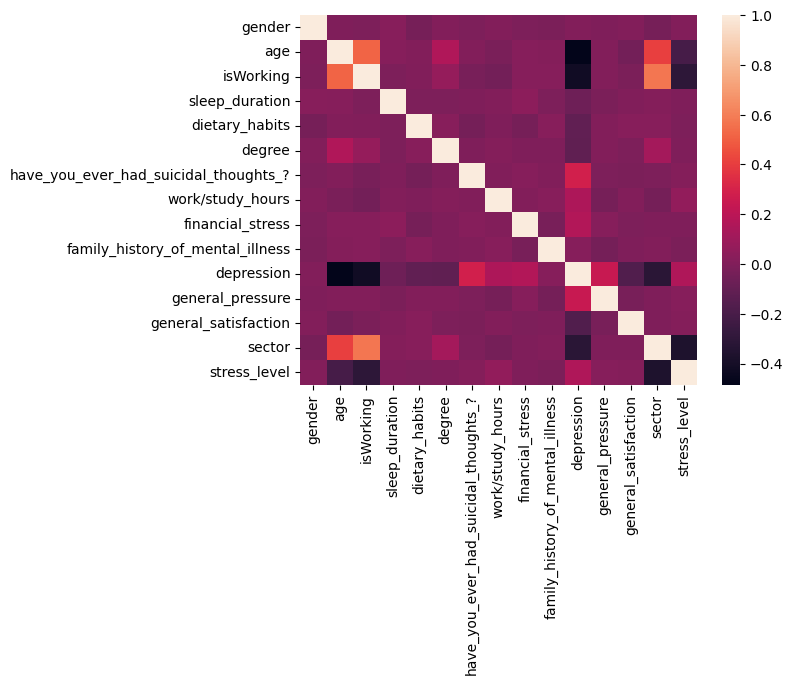

In [7]:
forestPreditor = PsyPreditor(
    "depression",
    cleanerRoutine._dataframe
)

forestPreditor.preditorRoutine(
    testSize= 0.4,
    randomNess= 42,
)

In [8]:
print(forestPreditor.classification_report)

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       898
           1       0.68      0.90      0.77       125

    accuracy                           0.94      1023
   macro avg       0.83      0.92      0.87      1023
weighted avg       0.95      0.94      0.94      1023



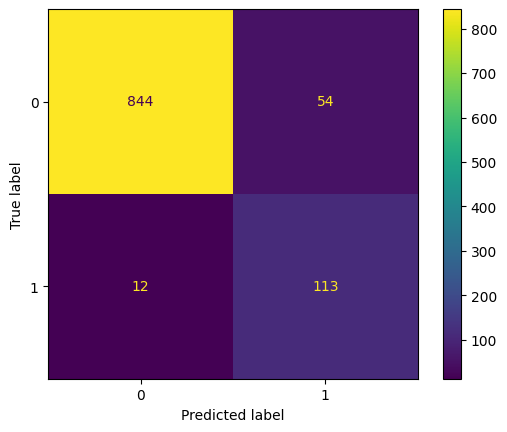

In [9]:
forestPreditor.matrix.plot()

In [31]:
forestPreditor._best_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [24]:
# The Forest prediction result
forestPreditor.prediction

,0
0,0
1,0
2,0
3,0
4,0
...,...
1018,0
1019,1
1020,0
1021,0


In [12]:
# The Forest model accuracy
forestPreditor.accuracy

0.9354838709677419

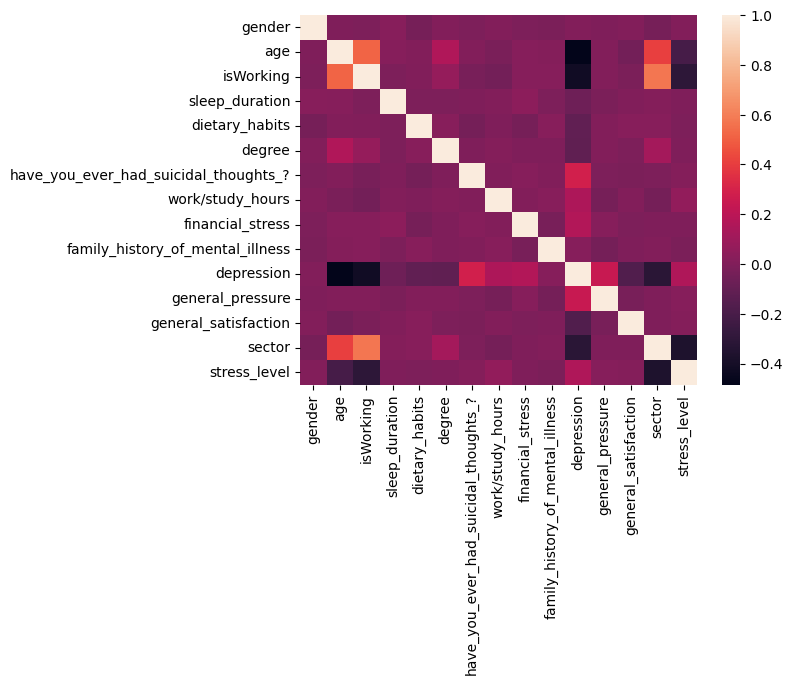

In [14]:
# Creating a model based on KNN
neighborsPreditor = PsyPreditor(
    "depression",
    cleanerRoutine._dataframe
)

# Running the model routine
neighborsPreditor.preditorRoutine(
    testSize=0.4,
    randomNess= 42,

    # These methods in specific are quite unusual, lets be honest
    # leaf size determines the complexity of the process, while n_jobs determine
    # how many CPU's will be used to process all the routine
    paramGrid= {
        'n_neighbors': [3, 5, 7],
        'leaf_size': [30, 50, 70],
        'n_jobs': [None, -2, -4]
    },
    usedModel= KNeighborsClassifier()
)

In [17]:
# A general classification report
print(neighborsPreditor.classification_report)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       871
           1       0.65      0.71      0.68       152

    accuracy                           0.90      1023
   macro avg       0.80      0.82      0.81      1023
weighted avg       0.90      0.90      0.90      1023



In [20]:
# All the relevant params used by the best model
neighborsPreditor._best_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 50,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [25]:
neighborsPreditor.prediction

,0
0,0
1,0
2,0
3,0
4,0
...,...
1018,0
1019,1
1020,0
1021,0


In [21]:
# The current KNN Accuracy
neighborsPreditor.accuracy

0.8993157380254154

In [32]:
neighborsPreditor._best_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 50,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

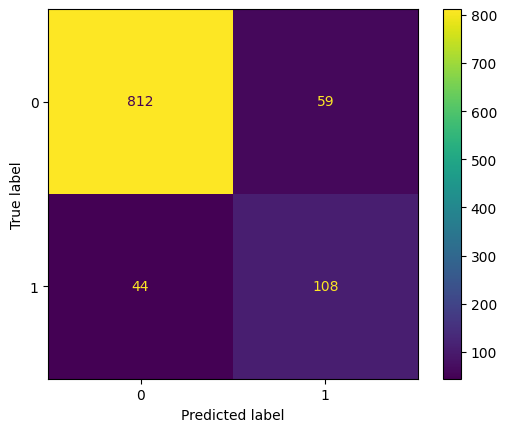

In [23]:
# A Matrix showing us all the FP, TP, FN and TN
neighborsPreditor.matrix.plot()

In [27]:
# Seems tricky and silly, but we can see that they share 90% of the results
accuracy_score(forestPreditor.prediction, neighborsPreditor.prediction)

0.9032258064516129

In [33]:
print(classification_report(forestPreditor.prediction, neighborsPreditor.prediction))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       898
           1       0.59      0.71      0.64       125

    accuracy                           0.90      1023
   macro avg       0.77      0.82      0.79      1023
weighted avg       0.91      0.90      0.91      1023

